In [19]:
import os, sys, glob, json, contextlib
import librosa
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

# deal with a known bug in sklearn that pollutes stdout: https://stackoverflow.com/questions/52596204/the-imp-module-is-deprecated
with contextlib.redirect_stderr(None):
    from sklearn import metrics

In [3]:
%load_ext autoreload
%autoreload 1

In [24]:
%aimport dataloader
%aimport train
%aimport model
from IPython.display import display, Audio

Loaded mean and invstd from: ../train_data/mean.txt ../train_data/invstd.txt
Loading file: 64031.wav
Loading file: 97752001.wav
Loading file: 97752002.wav
Loading file: 97752003.wav
Loading file: 97752004.wav
Loading file: 97752005.wav
Loading file: 97752006.wav
Loading file: 97752007.wav
Loading file: 97752008.wav
Loading file: 97752009.wav
Loading file: 9775200A.wav
Loading file: 9775200B.wav
Loading file: 9775200C.wav
Loading file: 9775200D.wav
Loading file: 9775200E.wav
Loading file: 9775200F.wav
Loading file: 9775200G.wav
Loading file: 9775200H.wav
Loading file: 9775200I.wav
Loading file: 9775200J.wav
Loading file: 9775200K.wav
Loading file: 9775200L.wav
Loading file: 9775200M.wav
Loading file: 9775200N.wav
Loading file: 9775200O.wav
Loading file: 9775200P.wav
Loading file: 9775200Q.wav
Loading file: 9775200R.wav
Loading file: 9775200S.wav
Loading file: 9775200T.wav
Loading file: 9775200U.wav
Loading file: 9775200V.wav
Loading file: 9775200W.wav
Loading file: 9775200X.wav
Loading 

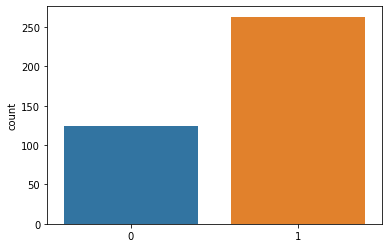

In [49]:
dev_dataset = dataloader.AudioFileDataset(
    "../train_data/wav","../train_data/dev.tsv",2,2,mean="../train_data/mean.txt",invstd="../train_data/invstd.txt"
)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, drop_last=False)
print("Total dataset size:",len(wav_dataset))
labels = [l[2] for l in wav_dataset.windows]
sns.countplot(labels)

In [56]:
net, curr_epoch = model.get_model_or_checkpoint("ResNet_slim","../../scratch/",1,epoch=4)
net = net.eval()

In [57]:
preds = []
targets = []
for i, (data,target) in enumerate(dev_dataloader):
    data, target = data.unsqueeze(1).float().cuda(), target.cuda() 
    pred = net(data)
    preds.append(torch.argmax(pred, dim=1).cpu().item())
    targets.append(target.cpu().item())

In [58]:
print(metrics.classification_report(targets,preds))
print(metrics.confusion_matrix(targets,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.68      1.00      0.81       263

   micro avg       0.68      0.68      0.68       387
   macro avg       0.34      0.50      0.40       387
weighted avg       0.46      0.68      0.55       387

[[  0 124]
 [  0 263]]


C:\Users\AKMAHAJA\AppData\Local\Continuum\anaconda3\envs\p36tfgpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AKMAHAJA\AppData\Local\Continuum\anaconda3\envs\p36tfgpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AKMAHAJA\AppData\Local\Continuum\anaconda3\envs\p36tfgpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
